In [1]:
% Path variables which are necessary
addpath([pwd filesep 'libsvm']);
addpath(pwd);

% Some variables used to make pretty plots
col = [0.9047    0.1918    0.1988
    0.2941    0.5447    0.7494
    0.3718    0.7176    0.3612
    1.0000    0.5482    0.1000
    0.4550    0.4946    0.4722
    0.6859    0.4035    0.2412
    0.9718    0.5553    0.7741
    0.5313    0.3359    0.6523];

col = repmat(col,2,1);
col_fill = col;
col(9:end,:) = 0; % when plotting > 8 items, we make the outline black

marker = {'d','+','o','x','>','s','<','+','^'};
marker = repmat(marker,1,2);
ms = 12;
savefigflag=0;

In [2]:
svm_path = which('svmtrain');

fprintf('\n');
if strfind(lower(svm_path),'.mex') > 0
    fprintf('The path for svmtrain is: %s\n',svm_path);
    fprintf('libsvm is loaded properly! Carry on!\n');
else
    fprintf('Could not find LIBSVM. Make sure it''s added to the path.\n');
end

The path for svmtrain is: /home/alistairewj/mimic-workshop/mlcc/lab2-intro-ml/libsvm/svmtrain.mexa64
libsvm is loaded properly! Carry on!

```
% Option 1. This loads fisher iris instead of the ICU data
load fisheriris;
X = meas(:,1:3);
X_header = {'Sepal length','Sepal width','Petal length'};
y = double(strcmp(species,'virginica')==1);
clear meas species;
```

```
% Option 2. Extract the patient data using the query from your assignment
% Run the following to connect to the database

% STEP 1: Tell Matlab where the driver is
javaclasspath('sqlite-jdbc-3.8.11.2.jar') % use this for SQLite

% STEP 2: Connect to the Database
if exist('conn','var') != 1
conn = database('','','',...
    'org.sqlite.JDBC',['jdbc:sqlite:' pwd filesep 'data' filesep 'mimiciii_v1_3_demo.sqlite']);
end

% Option 2 (continued). Extract the patient data using the query from your assignment
% At the moment this query is long, and takes ~5 minutes
setdbprefs('DataReturnFormat','dataset')
query = makeQuery('mlcc1-problem-set-solutions.sql');
data = fetch(conn,query);

% now convert data to a cell array
data = dataset2cell(data);

% we can get the column names from the first row of the 'data' variable
header = data(1,:);
header{2} = 'OUTCOME';
header = regexprep(header,'_',''); % remove underscores
data = data(2:end,:);

% MATLAB sometimes reads 'null' instead of NaN
data(cellfun(@isstr, data) & cellfun(@(x) strcmp(x,'null'), data)) = {NaN};

% MATLAB sometimes has blank cells which should be NaN
data(cellfun(@isempty, data)) = {NaN};

% Convert the data into a matrix of numbers
% This is a MATLAB data type thing - we can't do math with cell arrays
data = cell2mat(data);

X = data(:,3:5);
X_header = header(3:5);
y = data(:,2);
```

In [3]:
% (Option 3) Load the ICU data from the .mat file provided

% Loads in 'X', 'X_header', and 'y' variables
load('MLCCData.mat'); 


idxData = ismember(header,{'Age','HeartRateMin','GCSMin'});

X = data(:,idxData);
X_header = header(idxData);
y = data(:,2);

X_header

X_header = 

    'Age'    'HeartRateMin'    'GCSMin'

In [4]:
% Data will have at least three columns: 
%   ICUSTAY_ID, OUTCOME, AGE

% the following loops display the data nicely
W = 5; % the maximum number of columns to print at one time
for o=1:floor(size(data,2)/W)
    idxColumn = (o-1)*W + 1 : o*W;
    if idxColumn(end) > size(data,2)
        idxColumn = idxColumn(1):size(data,2);
    end
    
    fprintf('%12s\t',header{idxColumn});
    fprintf('\n');
    for n=1:5
        for m=idxColumn
            fprintf('%12g\t',data(n, m));
        end
        fprintf('\n');
    end
    fprintf('\n');
end

ICUSTAYID	     OUTCOME	         Age	HeartRateMin	HeartRateMax	
      230834	           0	     23.6137	         111	         122	
      284549	           0	     86.7196	          59	          76	
      204985	           0	     74.2264	          70	          83	
      261097	           0	     51.3441	          91	          91	
      219258	           0	     51.4133	          58	         118	

   MeanBPMin	   MeanBPMax	 RespRateMin	 RespRateMax	      GCSMin	
          59	          64	          12	          22	          15	
          55	         108	          15	          25	          15	
     47.3333	          65	          12	          20	          15	
          87	          87	          19	          19	         NaN	
          59	     123.667	           9	          31	           8	

      GCSMax	BILIRUBINmin	BILIRUBINmax	CREATININEmin	CREATININEmax	
          15	         NaN	         NaN	         0.8	           1	
          15	         0.5	         0.5	         0.6	         0.7	
         

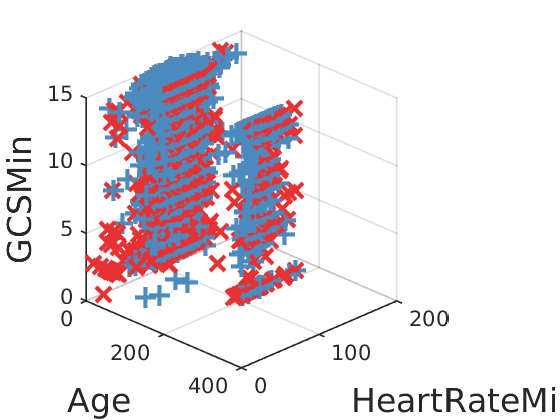

In [5]:
% Before we train a model - let's inspect the data
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

figure(1); clf; hold all;

plot3(X(idxTarget,1),X(idxTarget,2),X(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:)...
    ,'MarkerSize',10,'LineWidth',2);
plot3(X(~idxTarget,1),X(~idxTarget,2),X(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:)...
    ,'MarkerSize',10,'LineWidth',2);
grid on;

xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);

 % change the angle of the view to help inspection
set(gca,'view',[45 25]);

% 1) What do you see that is notable?
% ANSWER: for the ICU data...
%   there are ages ~ 300, these are de-identified ages

In [6]:
% Correct the erroneous ages
% Hint: the median age of patients > 89 is 91.6.
X( X(:,1) > 89, 1 ) = 91.6;

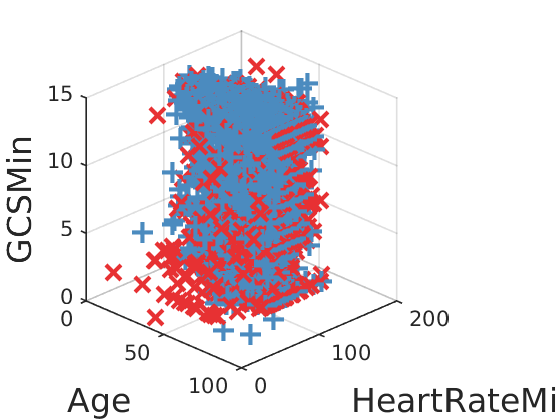

In [7]:
% Inspect the data correction
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

figure(1); clf; hold all;

plot3(X(idxTarget,1),X(idxTarget,2),X(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:)...
    ,'MarkerSize',10,'LineWidth',2);
plot3(X(~idxTarget,1),X(~idxTarget,2),X(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:)...
    ,'MarkerSize',10,'LineWidth',2);
grid on;

xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);

 % change the angle of the view to help inspection
set(gca,'view',[45 25]);

% 1) What do you see that is notable?
% ANSWER: for the ICU data...
%   patients with a minimum heart rate of 0 appear more likely to die
%   patients with "extreme" data (outside the massive blob in the middle) seem more likely to die

In [8]:
% Normalize the data!
% First get the column wise mean and the column wise standard deviation
mu = nanmean(X, 1);
sigma = nanstd(X, [], 1);

% Now subtract each element of mu from each column of X
X = bsxfun(@minus, X, mu);
X = bsxfun(@rdivide, X, sigma);

In [9]:
% We will be using libsvm. If you call svmtrain on its own, it lists the options available
svmtrain;

Usage: model = svmtrain(training_label_vector, training_instance_matrix, 'libsvm_options');
libsvm_options:
-s svm_type : set type of SVM (default 0)
	0 -- C-SVC		(multi-class classification)
	1 -- nu-SVC		(multi-class classification)
	2 -- one-class SVM
	3 -- epsilon-SVR	(regression)
	4 -- nu-SVR		(regression)
-t kernel_type : set type of kernel function (default 2)
	0 -- linear: u'*v
	1 -- polynomial: (gamma*u'*v + coef0)^degree
	2 -- radial basis function: exp(-gamma*|u-v|^2)
	3 -- sigmoid: tanh(gamma*u'*v + coef0)
	4 -- precomputed kernel (kernel values in training_instance_matrix)
-d degree : set degree in kernel function (default 3)
-g gamma : set gamma in kernel function (default 1/num_features)
-r coef0 : set coef0 in kernel function (default 0)
-c cost : set the parameter C of C-SVC, epsilon-SVR, and nu-SVR (default 1)
-n nu : set the parameter nu of nu-SVC, one-class SVM, and nu-SVR (default 0.5)
-p epsilon : set the epsilon in loss function of epsilon-SVR (default 0.1)
-m ca

In [10]:
% Using LIBSVM, train an SVM classifier with a linear kernel
model_linear = svmtrain(y, X, '-t 0');
% Atypically, LIBSVM receives options as a single string in the fourth input
% e.g. '-v 1 -b 1 -g 0.5 -c 1'

% Apply the classifier to the data set
pred = svmpredict(y, X, model_linear);

*
optimization finished, #iter = 1
nu = nan
obj = nan, rho = nan
nSV = 0, nBSV = 0
Total nSV = 0
Accuracy = 23.7494% (1524/6417) (classification)

We can interpret the above output. The code only ran for 1 iteration.
The objective function, "obj", is NaN.
We have 0 support vectors (nSV).

There's clearly a bug! What have we forgotten?

In [11]:
X(1:20,:)

ans =

   -2.9162    1.8213    0.9010
    1.0972   -0.9716    0.9010
    0.3026   -0.3808    0.9010
   -1.1526    0.7471       NaN
   -1.1482   -1.0253   -0.6094
   -1.1227    1.0156   -0.6094
    0.6375    0.1563   -1.6882
   -0.0080   -0.6494    0.6852
   -0.0054   -0.2197    0.9010
   -2.4675    1.0156       NaN
    0.3520   -1.1865    0.9010
    0.3905   -0.8105    0.6852
   -1.0092   -0.5957    0.0379
   -0.9954    2.3047    0.0379
   -0.9791   -0.2197    0.9010
   -0.9358    0.4248   -1.6882
   -1.4441    0.3711    0.9010
   -1.3662   -0.5420    0.9010
   -1.3657       NaN       NaN
   -1.2641   -0.2734   -0.1778

Looks like there is some missing data (not a number, or 'NaN') - when the code tries to do math with these missing values, it returns NaN. Imagine you try to calculate how far away NaN is from your current position - the result would be NaN. 

The SVM asks the question: "is this point above the hyperplane I'm learning or below the hyperplane I'm learning?". (Recall that a 'hyperplane' is just a high dimensional line). The idea is that we want all 'o' to be above the hyperplane and all 'x' to be below the hyperplane (i.e. we want to separate our data). But if we ask if 'NaN' is above or below the hyperplane, we just get 'NaN'. Then, when it sums across all points to see how many 'o' are above the plane, it also returns 'NaN'. This breaks the algorithm and it stops trying to optimize the separating plane.

In [12]:
% Make sure we impute a value for missing data, otherwise the models can't train
X( isnan(X) ) = 0;
% since we've normalized the data to have 0 mean, imputing 0 is equivalent to imputing the mean

In [13]:
X(1:20,:)

ans =

   -2.9162    1.8213    0.9010
    1.0972   -0.9716    0.9010
    0.3026   -0.3808    0.9010
   -1.1526    0.7471         0
   -1.1482   -1.0253   -0.6094
   -1.1227    1.0156   -0.6094
    0.6375    0.1563   -1.6882
   -0.0080   -0.6494    0.6852
   -0.0054   -0.2197    0.9010
   -2.4675    1.0156         0
    0.3520   -1.1865    0.9010
    0.3905   -0.8105    0.6852
   -1.0092   -0.5957    0.0379
   -0.9954    2.3047    0.0379
   -0.9791   -0.2197    0.9010
   -0.9358    0.4248   -1.6882
   -1.4441    0.3711    0.9010
   -1.3662   -0.5420    0.9010
   -1.3657         0         0
   -1.2641   -0.2734   -0.1778

Great, now let's try to find the hyperplane that best separates the data using our SVM.

In [14]:
% Using LIBSVM, train an SVM classifier with a linear kernel
model_linear = svmtrain(y, X, '-t 0');
% Atypically, LIBSVM receives options as a single string in the fourth input
% e.g. '-v 1 -b 1 -g 0.5 -c 1'

% Apply the classifier to the data set
pred = svmpredict(y, X, model_linear);

..
*
optimization finished, #iter = 2441
nu = 0.474988
obj = -3048.000037, rho = -1.000035
nSV = 3096, nBSV = 2969
Total nSV = 3096
Accuracy = 76.2506% (4893/6417) (classification)

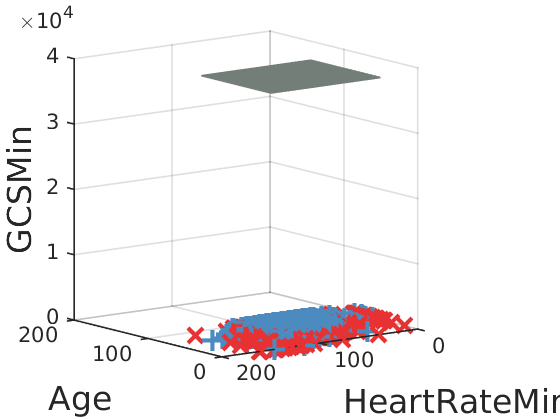

In [15]:
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

% We would like to plot the original data because it's in units we understand (e.g. age in years)
% we can un-normalize the data for plotting:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

xi = -3:0.25:3;
yi = -3:0.25:3;


% plot the hyperplane
w = model_linear.SVs' * model_linear.sv_coef;
b = model_linear.rho;
[XX,YY] = meshgrid(xi,yi);
ZZ=(b - w(1) * XX - w(2) * YY)/w(3);
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);
mesh(XX,YY,ZZ,'EdgeColor',col(5,:),'FaceColor','none');

%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

There is a word for this separating hyperplane: bad. It's so far away from our data it simply classifies everything as 0, or 'below the hyperplane'. This is not a very useful classifier - it's simply predicting all patients will survive. The question is, why is this happening?

In [16]:
fprintf('Number of patients who die:  %g.\n',sum(y==1));
fprintf('Number of patients who live: %g.\n',sum(y==0));

Number of patients who die:  1524.
Number of patients who live: 4893.

The answer lies in the class balance: we have almost 3 times as many patients who live compared to patients who die. The optimization algorithm will never make a perfect boundary: it has to determine a balance between misclassifying patients who survive and misclassifying patients who die. The simplest solution is just to say everyone survives. How do we fix this?

A common approach in machine learning for the unbalanced class problem is to either:
1. Subsample the bigger class (i.e. only use 1524 of our 4893 surviving patients)
2. Upsample the smaller class (i.e. copy the 1524 non-surviving patients until we have 4893)

We will try the first approach.

In [17]:
N0 = sum(y==0);
N1 = sum(y==1);

% we randomly pick 0s so that we don't accidentally pick a biased subset
% for example, if X was sorted by age, we would only get young people by selecting the first N1 rows
% if you know X isn't sorted, then this is an excessive step
% still, it's safer to randomize the indices we select just incase!
rng(777,'twister'); % ensure we always get the same random numbers
[~,idxRandomize] = sort(rand(N0,1));

idxKeep = find(y==0); % find all the negative outcomes
idxKeep = idxKeep(idxRandomize(1:N1)); % pick a random N1 negative outcomes
idxKeep = [find(y==1);idxKeep]; % add in the positive outcomes
idxKeep = sort(idxKeep); % probably not needed but it's cleaner

In [18]:
X_train = X(idxKeep,:);
y_train = y(idxKeep);

In [19]:
% Using LIBSVM, train an SVM classifier with a linear kernel
model_linear = svmtrain(y_train, X_train, '-t 0');
% Atypically, LIBSVM receives options as a single string in the fourth input
% e.g. '-v 1 -b 1 -g 0.5 -c 1'

% Apply the classifier to the data set
% Note, we can apply the predictions to *all* the data, instead of just our training set
[pred,acc,dist] = svmpredict(y, X, model_linear);

....
**.
*
optimization finished, #iter = 4929
nu = 0.844887
obj = -2574.917447, rho = -0.303950
nSV = 2585, nBSV = 2566
Total nSV = 2585
Accuracy = 66.9783% (4298/6417) (classification)

Our accuracy has actually *decreased* from 76% to 66.9%. This is because our classifier is actually trying now: while this classifier may have lower accuracy, it may have better performance in metrics which more appropriately factor in the unbalanced classes.

Note also that we have two other outputs: 
* 'acc' - the accuracy of the model
* 'dist' - the distance of each observation point to the hyperplane

Let's look at the distance measure.

In [20]:
[pred(45:50),dist(45:50),y(45:50)]

ans =

    1.0000   -0.5003         0
         0    1.0001         0
         0    1.0001         0
         0    0.9999         0
         0    1.0001         0
         0    0.1662         0

Note that LIBSVM outputs negative distances for positive cases and positive distances for negative cases. When we later try to calculate the AUROC, we need to rank the predictions in ascending order. It will be much more convenient to do this if LIBSVM instead assigned positive distances for positive cases and negative distances for negative cases (also it makes more intuitive sense).

LIBSVM assigns the first row of the training data to positive distances - therefore, in order to to ensure positive cases get positive distances, we just need to put a positive case as the first row.

In [21]:
idx1 = find(y_train==1,1);
idxTemp = 1:numel(y_train);

% create an index to ensure the first observation in the data is a positive outcome
idxTemp(1) = idx1;
idxTemp(idx1) = 1;
X_train = X_train(idxTemp,:);
y_train = y_train(idxTemp);

% retrain the RBF and linear SVM
model_linear = svmtrain(y_train, X_train, '-t 0 -q');
model_rbf = svmtrain(y_train, X_train, '-t 2 -q');

% Apply the classifier to the data set
[pred,acc,dist] = svmpredict(y, X, model_rbf, '-q');

% look at a random set of predictions
[pred(45:50),dist(45:50),y(45:50)]

ans =

    1.0000    0.4136         0
         0   -1.0191         0
         0   -0.9836         0
         0   -0.2166         0
         0   -1.0413         0
    1.0000    1.1730         0

Because we ensured the first training observation was a positive case (i.e. the first row in `X_train` corresponded to a 1 in `y_train`), LIBSVM now attempts to classify positive cases as `1`. Hurray! This is just a technical detail and it saves us the effort of having to invert the distances when we try to use them later to calculate the AUROC.

Note also we used the '-q' option to make LIBSVM quiet.

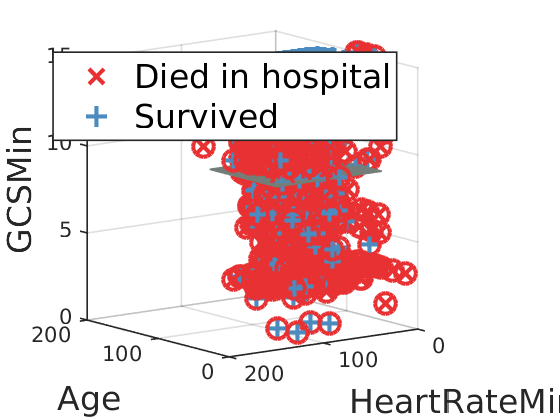

In [22]:
% Evaluate the model qualitatively

figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

% We would like to plot the original data because it's in units we understand (e.g. age in years)
% we can un-normalize the data for plotting:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

xi = -3:0.25:3;
yi = -3:0.25:3;


% plot the hyperplane
w = model_linear.SVs' * model_linear.sv_coef;
b = model_linear.rho;
[XX,YY] = meshgrid(xi,yi);
ZZ=(b - w(1) * XX - w(2) * YY)/w(3);
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);
mesh(XX,YY,ZZ,'EdgeColor',col(5,:),'FaceColor','none');

legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

Much better! The hyperplane has picked somewhere in the middle of GCS to separate the data. GCS stands for Glasgow Coma Scale: it is a measure of a patient's neurological status. A value of 3 is equivalent to a coma, and a value of 15 is equivalent to normal neurological function. Our classifier has learned this, and now predicts that patients in a coma are more likely to die.

In [23]:
% Evaluate the model quantitatively

% First, we calculate the four "operating point" statistics
TP = sum( pred == 1 & y == 1 );
FP = sum( pred == 0 & y == 1 );

TN = sum( pred == 0 & y == 0 );
FN = sum( pred == 1 & y == 0 );

% Now we create the confusion matrix

cm = [TP, FP;
    TN, FN]

cm =

         930         594
        3200        1693

In [24]:
% We can also create the sensitivity/specificity measures

fprintf('\n');
fprintf('Sensitivity: %6.2f%%\n', 100 * TP / (TP+FN));
fprintf('Specificity: %6.2f%%\n', 100 * TN / (TN+FP));
fprintf('PPV: %6.2f%%\n', 100 * TP / (TP + FP));
fprintf('NPV: %6.2f%%\n', 100 * TN / (TN+FN));

fprintf('\n');

% all together

fprintf('%6g\t%6g\t%10.2f%% \n', cm(1,1), cm(1,2), 100 * TP / (TP + FP));
fprintf('%6g\t%6g\t%10.2f%% \n', cm(2,1), cm(2,2), 100 * TN / (TN+FN));
fprintf('%5.2f%%\t%5.2f%%\t%10.2f%% \n', 100 * TP / (TP+FN), 100 * TN / (TN+FP), 100 * (TP+TN)/(TP+TN+FP+FN));

Sensitivity:  35.46%
Specificity:  84.34%
PPV:  61.02%
NPV:  65.40%

   930	   594	     61.02% 
  3200	  1693	     65.40% 
35.46%	84.34%	     64.36%

For patients who die, our model detects 34.59% of them. Not the most sensitive of classifiers.

Furthermore, for patients who our model predicts to die, only 43.83% actually die. Which means that if our model predicts a patient to die, they are actually more likely to *live* than die. This may sound paradoxical at first but it is what the PPV tells us. However, patients who our model predicts to die are *more likely* to die than patients who our model predicts to live. How do I know this? We can calculate it:

In [25]:
%out.PositiveLR=(1-out.sens)/out.spec;

% what is the probability that we predict survival given the patient died?
% this is simply 1 - sensitivity
% recall sensitivity is "given the patient died, what is the probability we predicted death?"
% so 1 - sensitivity is "given the patient died, what is the probability we predicted survival?"
%1 - (TP / (TP+FP)) 

% what is the probability the patient survives given we predicted survival?
% this is the specificity

% so what are the odds the patient dies, given we predicted they survived


In [26]:
% Now let's try with an RBF kernel
% This is LIBSVM's most flexible kernel
% We specify it as '-t 2'

% train the model
model_rbf = svmtrain(y_train, X_train, '-t 2');

% Apply the classifier to the data set
[pred,acc,dist] = svmpredict(y, X, model_rbf);

..
*.
*
optimization finished, #iter = 3727
nu = 0.769785
obj = -2321.227506, rho = -0.615587
nSV = 2389, nBSV = 2312
Total nSV = 2389
Accuracy = 64.3603% (4130/6417) (classification)

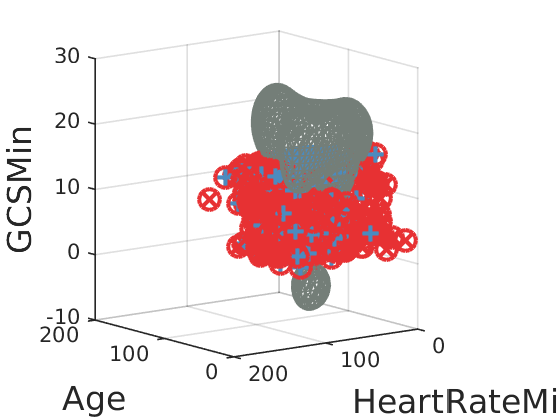

In [27]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot the model and the data
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

% reapply the SVM to a grid of all possible values
xi=-5:0.25:5;
yi=-5:0.25:5;
zi=-5:0.25:5;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbf, '-q');
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the new hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% standard info for the plot
%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

We see this hyperplane is a lot more flexible. It can be hard to interpret what's above and what's below - we can add in another isosurface which is much "closer" to what the SVM believes to be patients who died.

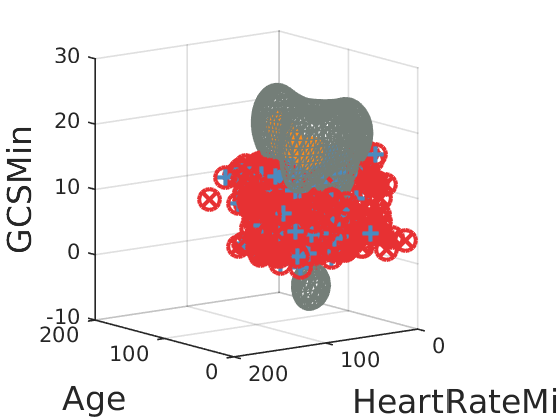

In [28]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot the model and the data
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

% reapply the SVM to a grid of all possible values
xi=-5:0.25:5;
yi=-5:0.25:5;
zi=-5:0.25:5;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbf, '-q');
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% plot the hyperplane closer to positive outcomes
% note the SVM is treating positive outcomes as "below" the hyperplane, which is why we look for -1
h3=patch(isosurface(XX,YY,ZZ,VV,-1)); 
set(h3,'facecolor','none','edgecolor',col(4,:));

% standard info for the plot
%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

In [29]:
% Evaluate the model

% First, we calculate the four "operating point" statistics
TP = sum( pred == 1 & y == 1 );
FP = sum( pred == 0 & y == 1 );

TN = sum( pred == 0 & y == 0 );
FN = sum( pred == 1 & y == 0 );

% Now we create the confusion matrix

cm = [TP, FP;
    FN, TN]

cm =

         930         594
        1693        3200

In [30]:
% We can also create the sensitivity/specificity measures

fprintf('\n');
fprintf('Sensitivity: %6.2f%%\n', 100 * TP / (TP+FN));
fprintf('Specificity: %6.2f%%\n', 100 * TN / (TN+FP));
fprintf('PPV: %6.2f%%\n', 100 * TP / (TP + FP));
fprintf('NPV: %6.2f%%\n', 100 * TN / (TN+FN));

fprintf('\n');

% all together

fprintf('%6g\t%6g\t%10.2f%% \n', cm(1,1), cm(1,2), 100 * TP / (TP + FP));
fprintf('%6g\t%6g\t%10.2f%% \n', cm(2,1), cm(2,2), 100 * TN / (TN+FN));
fprintf('%5.2f%%\t%5.2f%%\t%10.2f%% \n', 100 * TP / (TP+FN), 100 * TN / (TN+FP), 100 * (TP+TN)/(TP+TN+FP+FN));

Sensitivity:  35.46%
Specificity:  84.34%
PPV:  61.02%
NPV:  65.40%

   930	   594	     61.02% 
  1693	  3200	     65.40% 
35.46%	84.34%	     64.36%

In [31]:
% Directly compare the RBF model with the linear model

pred_linear = svmpredict(y, X, model_linear, '-q');
pred_rbf = svmpredict(y, X, model_rbf, '-q');

TP_l = sum( pred_linear == 1 & y == 1 );
FP_l = sum( pred_linear == 0 & y == 1 );
TN_l = sum( pred_linear == 0 & y == 0 );
FN_l = sum( pred_linear == 1 & y == 0 );

TP_r = sum( pred_rbf == 1 & y == 1 );
FP_r = sum( pred_rbf == 0 & y == 1 );
TN_r = sum( pred_rbf == 0 & y == 0 );
FN_r = sum( pred_rbf == 1 & y == 0 );

fprintf('Linear\tRBF\n');
fprintf('%4.2f%%\t%4.2f%%\tAccuracy\n', 100 * (TP_l+TN_l) / (TP_l+FN_l+TN_l+FP_l), 100 * (TP_r+TN_r) / (TP_r+FN_r+TN_r+FP_r));
fprintf('%4.2f%%\t%4.2f%%\tSensitivity\n', 100 * TP_l / (TP_l+FN_l), 100 * TP_r / (TP_r+FN_r));
fprintf('%6.2f%%\t%4.2f%%\tSpecificity\n', 100 * TN_l / (TN_l+FP_l), 100 * TN_r / (TN_r+FP_r));
fprintf('%6.2f%%\t%4.2f%%\tPPV\n', 100 * TP_l / (TP_l + FP_l), 100 * TP_r / (TP_r + FP_r));
fprintf('%6.2f%%\t%4.2f%%\tNPV\n', 100 * TN_l / (TN_l+FN_l), 100 * TN_r / (TN_r+FN_r));

Linear	RBF
67.45%	64.36%	Accuracy
34.87%	35.46%	Sensitivity
 80.81%	84.34%	Specificity
 42.72%	61.02%	PPV
 75.15%	65.40%	NPV

It's hard to tell which is better - RBF has higher sensitivity, specificity, PPV, but lower accuracy and NPV. Of course, we have to remember that accuracy is still not the best measure due to the imbalanced class problem. Let's look at the area under the receiver operator characteristic curve (AUROC). This is a useful measure which summarizes the operating point statistics over all operating points.

In [32]:
N_POS = sum(y==1);
N_NEG = sum(y==0);

[pred_linear,~,dist_linear] = svmpredict(y, X, model_linear, '-q');
[pred_rbf,~,dist_rbf] = svmpredict(y, X, model_rbf, '-q');

[~,idxSort] = sort(dist_rbf,1,'ascend');
y_rbf=y(idxSort);

idxNegative = y_rbf==0;
%=== Count the number of negative targets below each element
auc_rbf = cumsum(idxNegative,1);
%=== Only get positive targets
auc_rbf = auc_rbf(~idxNegative);
auc_rbf = sum(auc_rbf,1); %=== count number who are negative
auc_rbf = auc_rbf./(N_POS * N_NEG);

[~,idxSort] = sort(dist_linear,1,'ascend');
y_linear=y(idxSort);

idxNegative = y_linear==0;
%=== Count the number of negative targets below each element
auc_linear = cumsum(idxNegative,1);
%=== Only get positive targets
auc_linear = auc_linear(~idxNegative);
auc_linear = sum(auc_linear,1); %=== count number who are negative
auc_linear = auc_linear./(N_POS * N_NEG);

clear y_linear y_rbf;

[auc_rbf, auc_linear]

ans =

    0.6695    0.6207

Looks like the AUROC for our RBF classifier is better! It's also nice to look at the ROC curve graphically, which helps interpret the value.

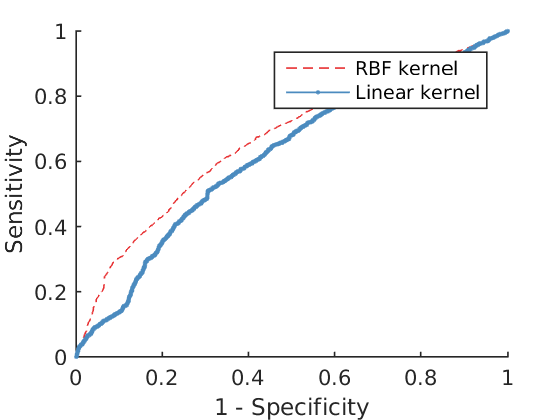

In [33]:
% Plot the RBF model and the linear model ROC curves

% We have a subfunction, 'calcRoc', which calculates the x and y values for the ROC
[roc_l_x, roc_l_y] = calcRoc(dist_linear, y);
[roc_r_x, roc_r_y] = calcRoc(dist_rbf, y);

figure(1); clf; hold all;
plot(roc_r_x, roc_r_y, '--','Color',col(1,:));
plot(roc_l_x, roc_l_y, '.-','Color',col(2,:));

legend('RBF kernel','Linear kernel');
xlabel('1 - Specificity');
ylabel('Sensitivity');

In [34]:
% Specify parameters in the RBF kernel
% The RBF kernel has some parameters of its own: gamma and capacity
% Let's set these to a different value then their defaults

gamma = 2;
capacity = 1;

% train the model
model_rbf_param = svmtrain(y_train, X_train, ['-t 2 -c ' num2str(2^(capacity)) ' -g ' num2str(2^(gamma))]);
[pred_rbf_param,~,dist_rbf_param] = svmpredict(y, X, model_rbf_param);

.....*.......*
optimization finished, #iter = 12061
nu = 0.699078
obj = -4017.879099, rho = -0.399601
nSV = 2432, nBSV = 1899
Total nSV = 2432
Accuracy = 70.6561% (4534/6417) (classification)

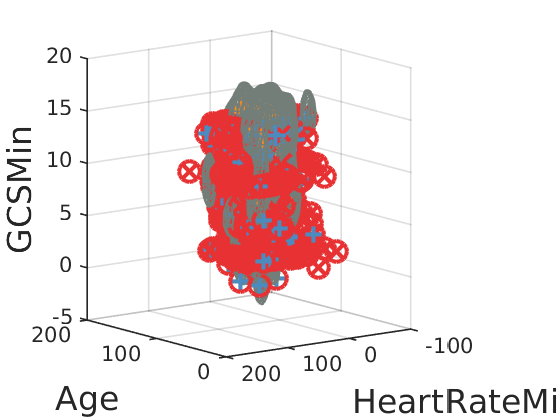

In [35]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot the model and the data
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

% reapply the SVM to a grid of all possible values
xi=-5:0.25:5;
yi=-5:0.25:5;
zi=-5:0.25:5;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbf_param, '-q');
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% plot the hyperplane closer to positive outcomes
% note the SVM is treating positive outcomes as "below" the hyperplane, which is why we look for -1
h3=patch(isosurface(XX,YY,ZZ,VV,-1)); 
set(h3,'facecolor','none','edgecolor',col(4,:));

% standard info for the plot
%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

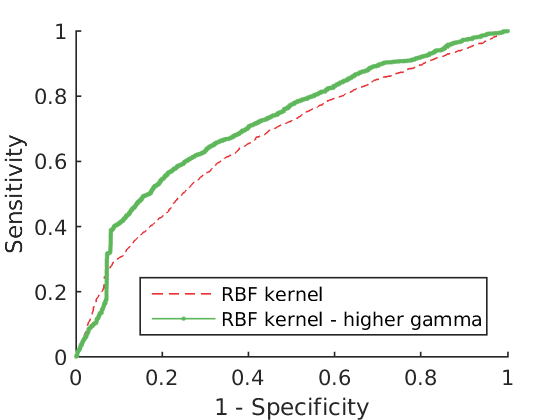

ans =

    0.6695    0.7157

In [36]:
[pred_rbf_param,~,dist_rbf_param] = svmpredict(y, X, model_rbf_param, '-q');

%=== Sensitivity (true positive rate)
[roc_rp_x, roc_rp_y, auc_rbf_param] = calcRoc(dist_rbf_param, y);

figure(1); clf; hold all;
plot(roc_r_x, roc_r_y, '--','Color',col(1,:));
plot(roc_rp_x, roc_rp_y, '.-','Color',col(3,:));

legend('RBF kernel','RBF kernel - higher gamma','Location','SouthEast');
xlabel('1 - Specificity');
ylabel('Sensitivity');


[auc_rbf, auc_rbf_param]

Great! Our parameter tweaking has improved the AUROC. Let's see how much better we can make our model!

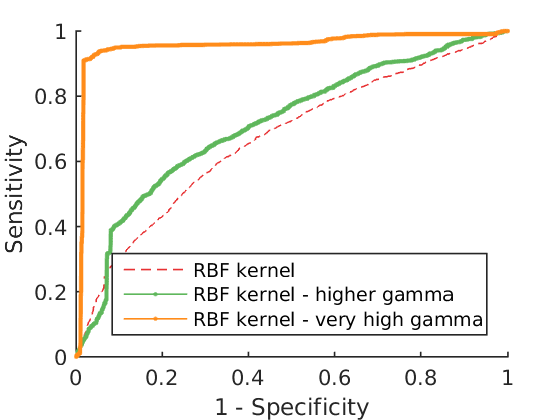

auc_rbf_opt =

    0.9558

In [37]:
% change gamma to improve the model
gamma = 10; % N.B. keep this as an integer as we exponentiate with it
capacity = 1;

% train the model
model_rbf_opt = svmtrain(y_train, X_train, ['-q -t 2 -c ' num2str(2^(capacity)) ' -g ' num2str(2^(gamma))]);
[pred_rbf_opt,~,dist_rbf_opt] = svmpredict(y, X, model_rbf_opt, '-q');


[roc_ro_x, roc_ro_y, auc_rbf_opt] = calcRoc(dist_rbf_opt, y);


figure(1); clf; hold all;
plot(roc_r_x, roc_r_y, '--','Color',col(1,:));
plot(roc_rp_x, roc_rp_y, '.-','Color',col(3,:));
plot(roc_ro_x, roc_ro_y, '.-','Color',col(4,:));

legend('RBF kernel','RBF kernel - higher gamma','RBF kernel - very high gamma', 'Location','SouthEast');
xlabel('1 - Specificity');
ylabel('Sensitivity');

auc_rbf_opt

Almost perfect AUROC! Awesome! Have we solved mortality prediction? Probably not yet :)

The issue here is we are evaluating the model on the *same data* that we develop it on. SVMs are flexible enough that they can "memorize" the data they have trained on - that is, they create a set of rules such as "if the age is 82, the heart rate is 40, and the gcs is 7, then the patient died". This set of rules is intuitively too specific - the fact thate one patient died with these exact values does not imply that all future patients will too. We would call our model "overfit" - it is memorizing the exact details of our training data rather then estimating a more generalizable model. The best way to assess if a model is overfit is to test it on new, never before seen data. To do this, we simply split our data into two sets: one for training and one for testing.

In [38]:
rng(625,'twister'); % set the seed so that everyone gets the same train/test sets
idxTrain = rand(size(X,1),1) > 0.5; % randomly assign training data

X_train = X(idxTrain,:);
y_train = y(idxTrain); % note that the first row is positive so LIBSVM will assign positive distances to positive cases

X_test = X(~idxTrain,:);
y_test = y(~idxTrain);

In [39]:
% Now we can train the model on the training data, and evaluate it on the test data
% We retrain all three models to compare the performances

% The original linear model
model_linear = svmtrain(y_train, X_train, '-q -t 0');

% The original RBF model
model_rbf = svmtrain(y_train, X_train, '-q -t 2');

% The RBF model with very high gamma
gamma = 10;
capacity = 1;
model_rbfopt = svmtrain(y_train, X_train, ['-q -t 2 -c ' num2str(2^(capacity)) ' -g ' num2str(2^(gamma))]);

In [40]:
% Evaluate the models on the training set
[pred_linear_tr,~,dist_linear_tr] = svmpredict(y_train, X_train, model_linear);
[   pred_rbf_tr,~,dist_rbf_tr] = svmpredict(y_train, X_train, model_rbf);
[pred_rbfopt_tr,~,dist_rbfopt_tr] = svmpredict(y_train, X_train, model_rbfopt);

% Evaluate the models on the test set
[pred_linear_test,~,dist_linear_test] = svmpredict(y_test, X_test, model_linear);
[pred_rbf_test,~,dist_rbf_test] = svmpredict(y_test, X_test, model_rbf);
[pred_rbfopt_test,~,dist_rbfopt_test] = svmpredict(y_test, X_test, model_rbfopt);

Accuracy = 76.5113% (2430/3176) (classification)
Accuracy = 78.0856% (2480/3176) (classification)
Accuracy = 97.1662% (3086/3176) (classification)
Accuracy = 75.9951% (2463/3241) (classification)
Accuracy = 77.0441% (2497/3241) (classification)
Accuracy = 73.8969% (2395/3241) (classification)

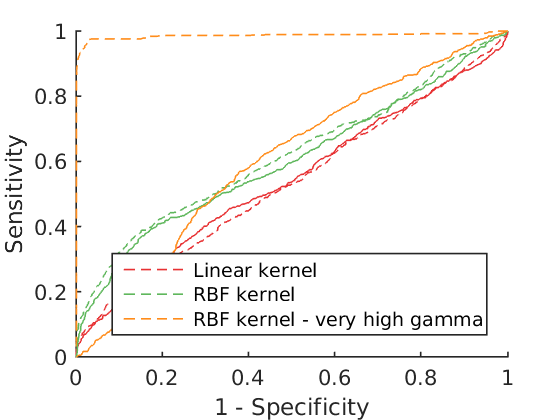

ans = 

    'Data'     'Linear'    'RBF'       'RBF with high gamma'
    'train'    [0.5345]    [0.6194]    [             0.9855]
    'test'     [0.5405]    [0.6006]    [             0.6002]

In [41]:
% Plot their AUROCs on the training set as dashed lines, and on the test set as solid lines

[roc_linear_tr_x, roc_linear_tr_y, auroc_linear_tr]  = calcRoc(dist_linear_tr, y_train);
[   roc_rbf_tr_x,    roc_rbf_tr_y, auroc_rbf_tr]     = calcRoc(   dist_rbf_tr, y_train);
[roc_rbfopt_tr_x, roc_rbfopt_tr_y, auroc_rbf_opt_tr] = calcRoc(dist_rbfopt_tr, y_train);

[roc_linear_test_x, roc_linear_test_y, auroc_linear_test]  = calcRoc(dist_linear_test, y_test);
[   roc_rbf_test_x,    roc_rbf_test_y, auroc_rbf_test]     = calcRoc(   dist_rbf_test, y_test);
[roc_rbfopt_test_x, roc_rbfopt_test_y, auroc_rbf_opt_test] = calcRoc(dist_rbfopt_test, y_test);

figure(1); clf; hold all;
plot(roc_linear_tr_x, roc_linear_tr_y, '--','Color',col(1,:));
plot(roc_rbf_tr_x, roc_rbf_tr_y, '--','Color',col(3,:));
plot(roc_rbfopt_tr_x, roc_rbfopt_tr_y, '--','Color',col(4,:));


plot(roc_linear_test_x, roc_linear_test_y, '-','Color',col(1,:));
plot(roc_rbf_test_x, roc_rbf_test_y, '-','Color',col(3,:));
plot(roc_rbfopt_test_x, roc_rbfopt_test_y, '-','Color',col(4,:));

legend('Linear kernel','RBF kernel','RBF kernel - very high gamma', 'Location','SouthEast');
xlabel('1 - Specificity');
ylabel('Sensitivity');


{ 'Data', 'Linear','RBF','RBF with high gamma';
  'train', auroc_linear_tr, auroc_rbf_tr, auroc_rbf_opt_tr;
  'test', auroc_linear_test, auroc_rbf_test, auroc_rbf_opt_test }

Above has given us a lot of information. The training set performances are the dashed lines, while the test set performances are the solid lines.

* The linear SVM has about equivalent performance on train and test sets - since the model is not very flexible (sometimes called "low variance"), it doesn't overfit as easily. This is true in general - there is a balance between flexible models and overfitting
* The RBF model performs better than the linear model, and while the training set performance is slightly better than the test set performance (in general you would expect this), it has not overfit, in that the test set performance is not significantly worse than we would expect
* The RBF model with very high gamma has overfit - the training set peformance is *much* higher than the test set performance. The training set performance implies that we should have perfect classification - but the truth is much worse, with a test set AUROC of 0.60.

We can visualize *just* the hyperplane of the high gamma RBF to visualize the overfitting.

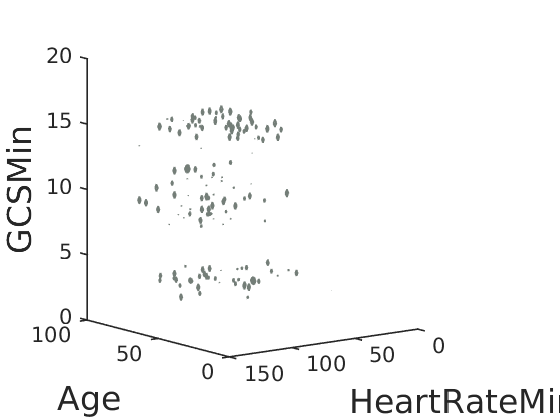

In [42]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot only the model hyperplane
figure(1); clf; hold all;

% create a grid of values in the main region of interest
xi=-3:0.1:3;
yi=-3:0.1:3;
zi=-3:0.1:3;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];

% apply the SVM to this grid
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbfopt, '-q');

% reshape the predictions into a 3 dimensions
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the separating hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% standard info for the plot
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

Here we can see that the hyperplane is hundreds of tiny grey dots. By setting a high gamma, we have set the hyperplane to be very close to each training point (technically, to each support vector). As a result, the separating boundary is simply a circle around each training point - clearly not a very generalizable model!

To pick the best gamma and capacity, we are going to learn a very important concept in machine learning: cross-validation. By now it's clear that using a validation set to periodically check how well our model is doing is a good idea. Note I called it a validation set: this is slightly different than a test set. A test set is used *once* at the end of all model development when you want to publish the results. A validation set is used repeatedly during model development to give you an idea of how the model would likely perform on the test set. 

Cross-validation in particular aims to solve the following trade-off:

1. Bigger validation sets result in better estimates of performance
2. Bigger validation sets result in smaller training sets and (usually) worse performance

The technique involves splitting the training set into subsets, or folds. You then train a model using data from all but one fold, and subsequently evaluate the model on that fold. Repeat this process for every fold that you have and voila - cross-validation! Let's try it out.

In [43]:
K = 5; % how many folds

[~,idxSplit] = sort(rand(size(X_train,1),1));
idxSplit = mod(idxSplit,K) + 1;

auroc = zeros(1,K);
for k=1:K
    
    idxDevelop  = idxSplit ~= k;
    idxValidate = idxSplit == k;
    
    model = svmtrain(y_train(idxDevelop), X_train(idxDevelop,:), '-q -t 2');
    [pred,~,dist] = svmpredict(y_train(idxValidate), X_train(idxValidate,:), model);
    
    if (pred(1) == 0 && dist(1) > 0) || (pred(1) == 1 && dist(1) < 0)
        % flip the sign of dist to ensure that the AUROC is calculated properly
        % the AUROC expects predictions of 1 to be assigned increasing distances
        dist = -dist;
    end
    [~, ~, auroc(k)] = calcRoc(dist, y_train(idxValidate));
end

auroc

Accuracy = 78.2677% (497/635) (classification)
Accuracy = 76.8868% (489/636) (classification)
Accuracy = 75.9055% (482/635) (classification)
Accuracy = 78.5827% (499/635) (classification)
Accuracy = 77.7953% (494/635) (classification)

auroc =

    0.6029    0.5944    0.5806    0.5948    0.5650

As we can see, we get some variation in the AUROC - each validation set is slightly different - and each AUROC is a noisy estimate of the true performance because we have a limited number of observations.

Cross-validation is often used to tune hyperparameters of a model. Hyperparameters are the same as parameters, except they control how the model is trained. For example, gamma and capacity are hyperparameters, and control how big the circles are and how many errors we allow the model to make.

These values are very important - and we can use cross-validation to set them to better values than the default. How we do this is simple - we try a bunch of values, and those which work best in cross-validation are the ones we pick. This is called a grid search.

In [46]:
% set the pseudo random number generator seed so our results are consistent
rng(90210,'twister');

K = 5; % how many folds
[~,idxSplit] = sort(rand(size(X_train,1),1));
idxSplit = mod(idxSplit,K) + 1;

gamma_grid = -5:5:5;
capacity_grid = -5:5:5;

G = numel(gamma_grid);
C = numel(capacity_grid);


auroc = zeros(G,C,K);
for c=1:C
for g=1:G
for k=1:K
    
    idxDevelop  = idxSplit ~= k;
    idxValidate = idxSplit == k;
    
    gamma = gamma_grid(g);
    capacity = capacity_grid(c);
    
    model = svmtrain(y_train(idxDevelop), X_train(idxDevelop,:), ['-q -t 2 -g ' num2str(2^gamma) ' -c ' num2str(2^capacity)]);
    [pred,~,dist] = svmpredict(y_train(idxValidate), X_train(idxValidate,:), model, '-q');
    
    if (pred(1) == 0 && dist(1) > 0) || (pred(1) == 1 && dist(1) < 0)
        % flip the sign of dist to ensure that the AUROC is calculated properly
        % the AUROC expects predictions of 1 to be assigned increasing distances
        dist = -dist;
    end
    [~, ~, auroc(g,c,k)] = calcRoc(dist, y_train(idxValidate));
end
end
end

% it's easiest to look at the mean AUROC across all the folds, rather than all 5
mean(auroc,3)

ans =

    0.6023    0.6126    0.6127    0.6057
    0.6005    0.6002    0.5775    0.5612
    0.5876    0.5875    0.5632    0.5548

We can see that some values are better than others. We're looking for a maximum somewhere in these values. Grid search is a lot like mountain climbing - you keep going until you find the peak. We'll just pick the values which gave us the best performance here - in practice you would probably make this grid bigger with smaller step sizes to get better hyperparameters.

It looks like the 1st row (gamma = -5) and 3rd column (capacity = 5) have the best performance. These will be the hyperparameters we select for our final model.

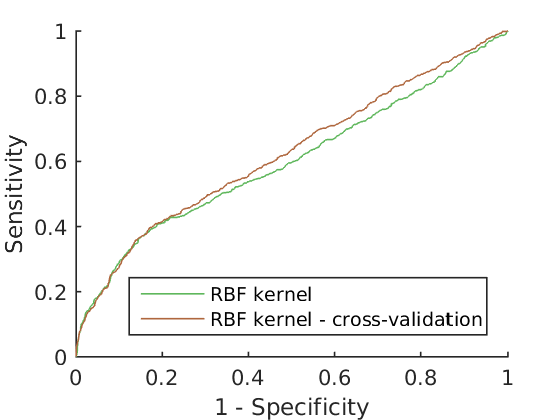

In [48]:
gamma = -5;
capacity = 5;

model_rbfcv = svmtrain(y_train, X_train, ['-q -t 2 -g ' num2str(2^gamma) ' -c ' num2str(2^capacity)]);

[~,~,dist_rbfcv_tr]   = svmpredict(y_train, X_train, model_rbfcv, '-q');
[~,~,dist_rbfcv_test] = svmpredict( y_test,  X_test, model_rbfcv, '-q');



[roc_rbfcv_tr_x, roc_rbfcv_tr_y, auroc_rbfcv_tr] = calcRoc(dist_rbfcv_tr, y_train);
[roc_rbfcv_test_x, roc_rbfcv_test_y, auroc_rbfcv_test] = calcRoc(dist_rbfcv_test, y_test);

figure(1); clf; hold all;
plot(roc_rbf_test_x, roc_rbf_test_y, '-','Color',col(3,:));
plot(roc_rbfcv_test_x, roc_rbfcv_test_y, '-','Color',col(6,:));

legend('RBF kernel','RBF kernel - cross-validation', 'Location','SouthEast');
xlabel('1 - Specificity');
ylabel('Sensitivity');

We can see that with relatively little effort we've eeked out some extra performance in our model, essentially for free. This is the power of cross-validation. We could likely improve the model more, but the time needed to do the grid search would become longer (changing gamma and capacity to very large or very small values can drastically increase the SVM training time). This is the main drawback of cross-validation - it takes time.

With your new skills in hand, you're ready to practice on your own! Try the following exercises on the *full* dataset, not just the three features we've examined.

1. Train an SVM using cross-validation to pick capacity and gamma
2. Train a logistic regression model
4. Train a random forest

In [ ]:
% Prepare the data for model development
rng(128301,'twister');

X = data(:,3:end);
y = data(:,2);

% set aside 30% of the data for final testing
idxTest = rand(size(data,1),1) > 0.7;
X_test = X(idxTest,:);
y_test = y(idxTest);

X_train = X(~idxTest,:);
y_train = y(~idxTest);



% remember to pick a balanced subset!
N0 = sum(y_train==0);
N1 = sum(y_train==1);

[~,idxRandomize] = sort(rand(N0,1));

idxKeep = find(y_train==0); % find all the negative outcomes
idxKeep = idxKeep(idxRandomize(1:N1)); % pick a random N1 negative outcomes
idxKeep = [find(y_train==1);idxKeep]; % add in the positive outcomes
idxKeep = sort(idxKeep); % probably not needed but it's cleaner

X_train = X_train(idxKeep,:);
y_train = y_train(idxKeep);

In [ ]:
% Train an SVM using all you've learned!

% don't forget to normalize the data and impute the mean for missing values

In [ ]:
% Train a logistic regression model
help glmfit; % used to train the model, look at 'binomial'
help glmval; % used to make predictions, look at 'logit'

In [ ]:
% Train a random forest
help treebagger;
